In [6]:
import pandas as pd
import numpy as np
import json
import os
from helper import load_data, load_data_im2recipe
from sklearn.feature_extraction import DictVectorizer
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.neighbors import NearestNeighbors
import requests
from food_extractor.food_model import FoodModel
import seaborn as sns
import pickle

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# - Load the data

## Yummly data

In [33]:
df_yummly = load_data(cache=False, lists_folder='../raw_data/lists/', recipes_folder='../raw_data/sample_recipes/')
df_yummly.head()

,id,recipeName,ingredients
0,Yakitori-1364355,Yakitori,"[soy, mirin, sake, sugar, chicken breasts, gre..."
1,Unagi-Don-_Unadon_-1685775,Unagi Don (Unadon),"[unagi, sake, steamed rice, soy sauce, mirin, ..."
2,Pork-ramen-soup-310007,Pork Ramen Soup,"[canola oil, boneless pork chops, black pepper..."
3,YAKITORI-DONBURI-975550,YAKITORI DONBURI,"[ground beef, mirin, soy sauce, brown sugar, r..."
4,Pork-Ramen-1436556,Pork Ramen,"[slab bacon, pork shoulder, garlic, medium car..."


## im2recipe data

In [8]:
df_im2recipe = load_data_im2recipe(recipes_folder='../raw_data/sample_im2recipes/')
df_im2recipe.head()

,id,recipeName,ingredients
0,000095fc1d,Yogurt Parfaits,"[yogurt greek plain nonfat, strawberries raw, ..."
1,00051d5b9d,"Salt Free, Low Cholesterol Sugar Cookies Recipe","[sugars granulated, oil corn peanut and olive,..."
2,00059b093b,Honey Sriracha Chicken Wings,[chicken broilers or fryers wing meat and skin...
3,0005fc89f7,Shrimp and Caper Salad,[crustaceans shrimp raw (not previously frozen...
4,0006ca31f4,Natural Peanut Butter Chocolate Bon Bons,"[cocoa dry powder unsweetened, honey, peanut b..."


## Concat Yummly & im2recipe

In [9]:
df = pd.concat([df_yummly, df_im2recipe]).reset_index(drop=True)
print(df_yummly.shape)
print(df_im2recipe.shape)
print(df.shape)

(385, 3)
(486, 3)
(871, 3)


### ADD CO2

In [10]:
df.head()

,id,recipeName,ingredients
0,Yakitori-1364355,Yakitori,"[soy, mirin, sake, sugar, chicken breasts, gre..."
1,Unagi-Don-_Unadon_-1685775,Unagi Don (Unadon),"[unagi, sake, steamed rice, soy sauce, mirin, ..."
2,Pork-ramen-soup-310007,Pork Ramen Soup,"[canola oil, boneless pork chops, black pepper..."
3,YAKITORI-DONBURI-975550,YAKITORI DONBURI,"[ground beef, mirin, soy sauce, brown sugar, r..."
4,Pork-Ramen-1436556,Pork Ramen,"[slab bacon, pork shoulder, garlic, medium car..."


In [11]:
import random
df['co2'] = 100 * np.random.randn(df.shape[0]) + 1000

In [12]:
print('minimum is : ' + str(df['co2'].min()))
df.head()

minimum is : 654.8154231848773


,id,recipeName,ingredients,co2
0,Yakitori-1364355,Yakitori,"[soy, mirin, sake, sugar, chicken breasts, gre...",947.636173
1,Unagi-Don-_Unadon_-1685775,Unagi Don (Unadon),"[unagi, sake, steamed rice, soy sauce, mirin, ...",942.729782
2,Pork-ramen-soup-310007,Pork Ramen Soup,"[canola oil, boneless pork chops, black pepper...",965.674359
3,YAKITORI-DONBURI-975550,YAKITORI DONBURI,"[ground beef, mirin, soy sauce, brown sugar, r...",1040.336222
4,Pork-Ramen-1436556,Pork Ramen,"[slab bacon, pork shoulder, garlic, medium car...",1124.127685


# - Clean the ingredients

In [13]:
model = FoodModel("chambliss/distilbert-for-food-extraction")

In [14]:
df_cleaned = df.copy()

In [37]:
df_cleaned['ingredients2'] = df_cleaned['ingredients'].apply(lambda x : \
                                                                     [ing['text'] for ing in model.extract_foods(','.join([ing for ing in x]))[0]['Ingredient']])


In [42]:
#df_cleaned.drop(columns=['ingredients'], inplace=True)
df_cleaned.rename(columns={'ingredients2':'ingredients'}, inplace=True)
print(df_cleaned.shape)
df_cleaned.head(-10)

(871, 4)


,id,recipeName,co2,ingredients
0,Yakitori-1364355,Yakitori,947.636173,"[mirin, sake, sugar, chicken breasts, green on..."
1,Unagi-Don-_Unadon_-1685775,Unagi Don (Unadon),942.729782,"[sake, steamed rice, soy sauce, mirin, sugar]"
2,Pork-ramen-soup-310007,Pork Ramen Soup,965.674359,"[ola oil, pork chops, black pepper, kosher sal..."
3,YAKITORI-DONBURI-975550,YAKITORI DONBURI,1040.336222,"[ground beef, mirin, soy sauce, brown sugar, r..."
4,Pork-Ramen-1436556,Pork Ramen,1124.127685,"[bacon, pork shoulder, garlic, carrot, celery ..."
...,...,...,...,...
856,02db53ce91,Oyster Stew,1010.166465,"[sauce, oyster, celery, onions, spices pepper ..."
857,02db6db8ea,Salt Pork And Greens Recipe,1120.725675,"[pork, fresh loin tenderloin, turnip]"
858,02ded1955b,BBQ pork ribs,1005.199582,"[garlic powder, sugars brown, spices chili pow..."
859,02df03d24c,Sea Salt With Fennel Seeds and Thyme,1091.784805,"[fennel seed, spices marjoram, spices thyme, s..."


In [ ]:
df = df_cleaned.copy()

# Pipeline

## - Convert ingredients into dict

In [17]:
def convert_to_dict(arr):
    ''' Helper function to convect an array of ingredients to a dictionary '''
    d={}
    for a in arr:
        d[a]=1
    return d

In [18]:
# First we create a bag of words per recipe
df['bow'] = df.ingredients.apply(convert_to_dict)

## Pipeline

### Find he number of components

In [19]:
def find_n_components(df):
    import numpy as np 
    vect_test = DictVectorizer(sparse=False)
    X_test = vect_test.fit_transform(df.bow.tolist())
    pca_test = PCA(n_components=min(df.shape[0], X_test.shape[1]))
    pca_test.fit(X_test)
    n_components = np.argmax(pca_test.explained_variance_ratio_.cumsum() > 0.9)
    return n_components

In [20]:
n_components = find_n_components(df)
n_components

291

### Create Pipeline

In [21]:
def pipeline(n_components):
    pipe = Pipeline([
        ('dict_vectorizer', DictVectorizer(sparse=False)),
        ('pca', PCA(n_components=n_components))
    ])
    return pipe

In [22]:
pipe = pipeline(n_components)
X = pipe.fit_transform(df.bow.tolist())
X.shape

(871, 291)

# - Nearest Neighbor modeling

In [23]:
index_recipe = 2
n_neighbors = 5

nn = NearestNeighbors(n_neighbors=n_neighbors)
nn.fit(X)
X_test = X[index_recipe].reshape(-1,1).T
neighbors = nn.kneighbors(X=X_test, n_neighbors=n_neighbors, return_distance=True)

In [24]:
X_test.shape

(1, 291)

In [25]:
dict_to_plot = {
    'name':[],
    'distance':[], 
    'co2':[],
    'marker_size':[]
}

for rec in zip(neighbors[0][0], neighbors[1][0]):
    dict_to_plot['name'].append(df.iloc[rec[1]]['recipeName'])
    dict_to_plot['distance'].append(rec[0])
    dict_to_plot['co2'].append(df.iloc[rec[1]]['co2'])
    dict_to_plot['marker_size'].append((df.iloc[rec[1]]['co2']**7)/1000000000000000000)

df_to_plot = pd.DataFrame(dict_to_plot)
df_to_plot

,name,distance,co2,marker_size
0,Pork Ramen Soup,0.000000,965.674359,783.095811
1,Yakitori (Japanese Grilled Chicken),3.421128,977.468954,852.551863
2,Pork & Broccoli Stir-Fry,3.446143,1070.916632,1615.435583
3,Linguica Con Queso (Cheese-Grilled Sausage),3.571552,1003.042946,1021.496059
4,Yakiniku (Japanese Grilled Meat or BBQ),3.580352,959.405015,748.193429


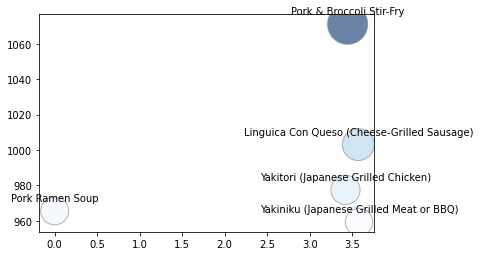

In [26]:
plt.scatter(df_to_plot['distance'], 
            df_to_plot['co2'], 
            s=df_to_plot['marker_size'], 
            c=df_to_plot['marker_size'], 
            cmap="Blues", 
            alpha=0.6, 
            edgecolors="grey", 
            linewidth=1, 
            label=df_to_plot['name'])

for x,y,z in zip(df_to_plot['distance'],df_to_plot['co2'],df_to_plot['name']):
    
    label = f"{z}"
    
    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

## Nearest neighbors with c02 filtering

### Create Pipeline

def pipeline(n_components):
    pipe = Pipeline([
        ('dict_vectorizer', DictVectorizer(sparse=False)),
        ('pca', PCA(n_components=n_components))
    ])
    return pipe

pipe = pipeline(n_components)
pipe.fit(df.bow.tolist())

sample_test = 
df_filtered = df[df['co2']]
X2 = pipe.transform(df.bow.tolist())

# Export the data

## Export the data

### Vectorized dataframe

In [27]:
with open("../foodprint.ai/data/cached_vectorized_data.pickle", "wb") as file:
    pickle.dump(pd.DataFrame(X, index=df.id), file)

### Informational dataframe

In [28]:
with open("../foodprint.ai/data/cached_informational_data.pickle", "wb") as file:
    pickle.dump(df, file)

## Export the pipeline

In [ ]:
with open("../foodprint.ai/data/pipeline.pickle", "wb") as file:
    pickle.dump(pd.DataFrame(X, index=df.id), file)

## Exporte the model

In [29]:
# Export pipeline as pickle file
with open("../models/nneighbors_model.pkl", "wb") as file:
    pickle.dump(nn, file)

# Test All

### Id is provided

In [30]:
id = 'Pork-ramen-soup-310007'

### load the data

In [46]:
# Load dataframe from pickle file
df_loaded = pickle.load(open("../foodprint.ai/data/cached_vectorized_data.pickle","rb"))

In [47]:
df_loaded.head()

,0,1,2,3,4,5,6,7,8,9,...,281,282,283,284,285,286,287,288,289,290
id,,,,,,,,,,,,,,,,,,,,,
Yakitori-1364355,-0.353806,0.999220,-0.200715,0.379974,0.168254,-0.142290,-0.378290,-0.148765,0.005069,0.079685,...,0.073059,0.057032,0.107048,0.056688,0.069363,-0.041214,0.005301,-0.011283,-0.005929,-0.076245
Unagi-Don-_Unadon_-1685775,-0.382455,1.164432,-0.245601,0.549309,0.272621,-0.389244,-0.585609,-0.211398,0.036710,0.127688,...,-0.079797,-0.021161,0.002013,-0.052319,-0.012897,-0.012998,-0.009860,-0.007369,0.187747,-0.074363
Pork-ramen-soup-310007,-0.519883,0.954891,-0.200681,0.341186,0.113570,-0.065693,0.141853,-0.005009,0.490105,0.256206,...,0.088457,-0.117316,-0.126929,0.029173,-0.006908,0.065811,-0.016248,-0.145355,0.088424,0.098802
YAKITORI-DONBURI-975550,-0.386306,0.957796,-0.192687,0.351233,0.151482,-0.260122,-0.197049,-0.043983,-0.094353,0.169310,...,-0.045888,0.061324,0.071691,-0.047037,-0.004942,-0.052357,-0.040199,0.034378,0.015324,0.052117
Pork-Ramen-1436556,-0.815049,0.849178,-0.234903,0.714602,0.370272,-0.538211,0.419926,0.122475,0.681596,-0.052846,...,-0.090468,0.062528,-0.049339,-0.089947,0.004328,0.106523,0.005663,0.120271,0.017372,0.045058


In [49]:
np.array(df_loaded).shape

(871, 291)

### Get the recipe

In [ ]:
recipe = np.array(df_loaded.loc[id]).reshape(-1,1).T

In [ ]:
recipe.shape

### Load the model

In [ ]:
# Load model from pickle file
nn_loaded = pickle.load(open("../models/nneighbors_model.pkl","rb"))

### find the neighbors

In [ ]:
n_neighbors = 5
neighbors = nn_loaded.kneighbors(X=recipe, n_neighbors=n_neighbors, return_distance=True)